In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-sign-detection/annotations/road732.xml
/kaggle/input/road-sign-detection/annotations/road518.xml
/kaggle/input/road-sign-detection/annotations/road717.xml
/kaggle/input/road-sign-detection/annotations/road362.xml
/kaggle/input/road-sign-detection/annotations/road492.xml
/kaggle/input/road-sign-detection/annotations/road612.xml
/kaggle/input/road-sign-detection/annotations/road252.xml
/kaggle/input/road-sign-detection/annotations/road592.xml
/kaggle/input/road-sign-detection/annotations/road24.xml
/kaggle/input/road-sign-detection/annotations/road841.xml
/kaggle/input/road-sign-detection/annotations/road686.xml
/kaggle/input/road-sign-detection/annotations/road862.xml
/kaggle/input/road-sign-detection/annotations/road361.xml
/kaggle/input/road-sign-detection/annotations/road34.xml
/kaggle/input/road-sign-detection/annotations/road363.xml
/kaggle/input/road-sign-detection/annotations/road474.xml
/kaggle/input/road-sign-detection/annotations/road397.xml
/kaggle/input/ro

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 17.5 MB/s eta 0:00:0000:01


In [3]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd

In [4]:
os.listdir("/kaggle/input/road-sign-detection")

['annotations', 'images']

In [5]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [7]:
print(extract_info_from_xml('/kaggle/input/road-sign-detection/annotations/road4.xml'))


{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [8]:
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov8(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [9]:
!mkdir annotations images labels

In [10]:
annotations = [os.path.join('/kaggle/input/road-sign-detection/annotations', x) for x in os.listdir('/kaggle/input/road-sign-detection/annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov8(info_dict)

100%|██████████| 877/877 [00:02<00:00, 307.19it/s]


In [11]:
annotations = [os.path.join('/kaggle/working/annotations', x) for x in os.listdir('/kaggle/working/annotations') if x[-3:] == "txt"]

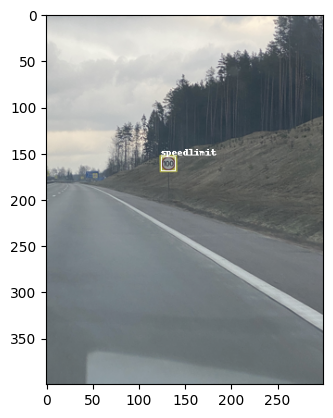

In [12]:
random.seed(55)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("working/annotations", "input/road-sign-detection/images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [13]:
# Read images and annotations
images = [os.path.join('/kaggle/input/road-sign-detection/images', x) for x in os.listdir('/kaggle/input/road-sign-detection/images')]
annotations = [os.path.join('/kaggle/working/annotations', x) for x in os.listdir('/kaggle/working/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [14]:
!mkdir images/train images/val images/test labels/train labels/val labels/test

In [15]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/kaggle/working/images/train/')
move_files_to_folder(val_images, '/kaggle/working/images/val/')
move_files_to_folder(test_images, '/kaggle/working/images/test/')
move_files_to_folder(train_annotations, '/kaggle/working/labels/train/')
move_files_to_folder(val_annotations, '/kaggle/working/labels/val/')
move_files_to_folder(test_annotations, '/kaggle/working/labels/test/')

In [16]:
yaml_content = """
train: /kaggle/working/images/train/ 
val:  /kaggle/working/images/val/
test: /kaggle/working/images/test/

# number of classes
nc: 4

# class names
names: ["trafficlight","stop", "speedlimit","crosswalk"]
"""

with open("/kaggle/working/road_sign.yaml", "w") as file:
    file.write(yaml_content)

In [17]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [18]:
from ultralytics import YOLO



In [19]:
import yaml

with open('/kaggle/working/road_sign.yaml', 'r') as file:
    try:
        yaml_content = yaml.safe_load(file)
        
        # Now you can check the content
        print(yaml_content)

    except yaml.YAMLError as exc:
        print(exc)

{'train': '/kaggle/working/images/train/', 'val': '/kaggle/working/images/val/', 'test': '/kaggle/working/images/test/', 'nc': 4, 'names': ['trafficlight', 'stop', 'speedlimit', 'crosswalk']}


In [20]:
import wandb
wandb.login(key="1491604ba6e00c304b7597a2ce5413a9964d26ec")


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [21]:
!ls


annotations  images  labels  road_sign.yaml


In [22]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [23]:
from ultralytics import YOLO
 
# Load the model.
model = YOLO('yolov8s.pt')
 
# Training.
results = model.train(
   data='road_sign.yaml',
   imgsz=640,
   epochs=200,
   batch=8,
   name='yolov8s_custom')

100%|██████████| 21.5M/21.5M [00:00<00:00, 187MB/s]
Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=road_sign.yaml, epochs=200, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
100%|██████████| 6.23M/6.23M [00:00<00:00, 131MB/s]
AMP: checks passed ✅
train: Scanning /kaggle/working/labels/train... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:01<00:00, 658.30it/s]
train: New cache created: /kaggle/working/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/labels/val... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<00:00, 760.82it/s]
val: New cache created: /kaggle/working/labels/val.cache
Plotting labels to runs/detect/yolov8s_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter gr

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr/pg0,▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▅▆▆▇▇▆▆▇▆▇▇█▇▇▇▇█▇▇█▇▇▇█▇█▇█▇██████████
metrics/mAP50-95(B),▁▄▅▅▅▆▆▆▇▆▆▆▇▇▆▇▇▇▆▇▇▇▇▇█▇▇▇█████▇█▇▇▇██
metrics/precision(B),▁▅▆▇▆▇▆▆▇▇▆▇▇▆▇▇▇█▇██▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇
metrics/recall(B),▁▅▅▅▇▇▆▆▇▆▇▇▇█▇▇▇█▇▇█▇█▇██▇█████▇█████▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▇▆▆▆▅▅▅▄▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁


In [24]:
metrics = model.val(data='/kaggle/working/road_sign.yaml', split = 'test')

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /kaggle/working/labels/test... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<00:00, 679.85it/s]
val: New cache created: /kaggle/working/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.86it/s]
                   all         88        126      0.983       0.92      0.949      0.806
          trafficlight         88         20      0.978        0.8      0.847      0.545
                  stop         88          7          1      0.991      0.995      0.931
            speedlimit         88         76          1      0.993      0.995      0.928
             crosswalk         88         23      0.954      0.896      0.961      0.821
Speed: 1.3ms preprocess, 8.2ms inference, 0.0ms loss,

In [25]:
metrics = model.val(data='/kaggle/working/road_sign.yaml', split = 'val')

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
val: Scanning /kaggle/working/labels/val.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.02it/s]
                   all         88        132      0.974      0.983      0.992      0.838
          trafficlight         88         19      0.938      0.947      0.982      0.681
                  stop         88         10          1      0.991      0.995      0.915
            speedlimit         88         81       0.96          1      0.995      0.932
             crosswalk         88         22          1      0.992      0.995      0.824
Speed: 0.9ms preprocess, 6.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolov8s_custom3


In [26]:
!yolo task=detect mode=val model=/kaggle/working/runs/detect/yolov8s_custom3/weights/best.pt name=yolov8s_eval data=road_sign.yaml imgsz=640

Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 419, in entrypoint
    model = YOLO(model, task=task)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 97, in __init__
    self._load(model, task)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 149, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py", line 628, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py", line 567, in torch_safe_load
    return torch.load(file, map_location='cpu'), file  # load
  File "/opt/conda/lib/python3.10/site-packages/torch/serialization.py", line 791, in load
    with _open_file_like(f, 'rb') as opened

In [27]:
results = model.val()

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
val: Scanning /kaggle/working/labels/val.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  8.04it/s]
                   all         88        132      0.974      0.983      0.992      0.838
          trafficlight         88         19      0.938      0.947      0.982      0.681
                  stop         88         10          1      0.991      0.995      0.915
            speedlimit         88         81       0.96          1      0.995      0.932
             crosswalk         88         22          1      0.992      0.995      0.824
Speed: 1.7ms preprocess, 4.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolov8s_custom4


In [28]:
results.box.map    # map50-95
results.box.map50  # map50
results.box.map75  # map75
results.box.maps   # a list contains map50-95 of each category

array([    0.68125,     0.91515,     0.93192,     0.82414])

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

In [30]:
def show_results(file):
    plt.figure(figsize=(30,30))
    img = np.asarray(Image.open(file))
    plt.imshow(img)
    plt.axis('off')
    ;

In [31]:
show_results('/kaggle/working/runs/detect/yolov8s_custom3/results.png')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/runs/detect/yolov8s_custom3/results.png'

<Figure size 3000x3000 with 0 Axes>

In [ ]:
show_results('/kaggle/working/runs/detect/yolov8s_custom4/F1_curve.png')


In [ ]:
show_results('/kaggle/working/runs/detect/yolov8s_custom4/confusion_matrix.png')

In [ ]:
show_results('/kaggle/working/runs/detect/yolov8s_custom3/labels_correlogram.jpg')

In [ ]:
show_results('/kaggle/working/runs/detect/yolov8s_custom4/R_curve.png')

In [ ]:
show_results('/kaggle/working/runs/detect/yolov8s_custom4/R_curve.png')

In [ ]:
show_results('/kaggle/working/runs/detect/yolov8s_custom4/PR_curve.png')

In [ ]:
show_results('/kaggle/working/runs/detect/yolov8s_custom4/val_batch1_pred.jpg')